In [ ]:
#default_exp peak_pattern_puzzle_solver 

# Solving the peak pattern puzzle 

> Which elements are hidden in our data cube?

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 

In [ ]:
#hide 
import os 
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#hide 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib notebook

In the previous section we saw how to explain the presence of specific in the individual hotmax spectra by  comparison with the instrument and element peak patterns by hand. Tedious work, but not too difficult. Let's now try to extract the algorithm for solving the peak pattern puzzle. As an example walk, let's walk through hotmax spectrum **#4**. In the plot we see thirteen peaks that exceed the noise threshold. We need to explain these peaks away, one by one. 

In [ ]:
from maxrf4u import plot_puzzle, HotmaxAtlas, DataStack

<IPython.core.display.Javascript object>


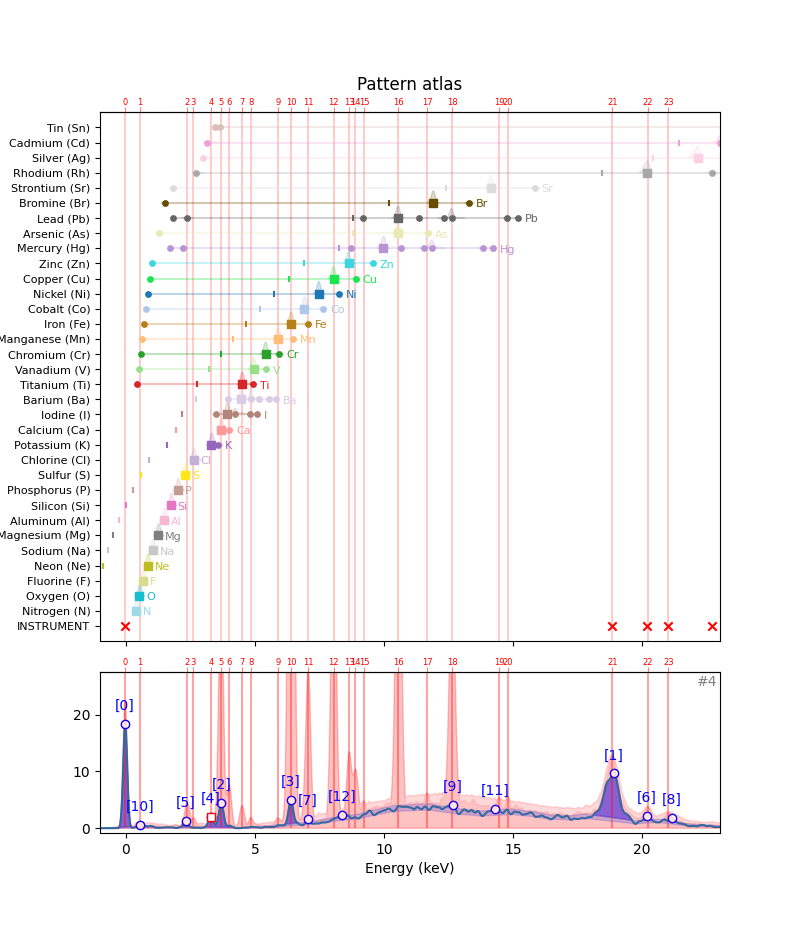

In [ ]:
fig, ax, ax1 = plot_puzzle('RP-T-1898-A-3689.datastack', 4)
ax.set_title('Pattern atlas');

Initially, in hotmax spectrum **#4** there are thirteen detected peaks that we need to explain. These peaks are numbered from highest to lowest.     